In [1]:
import itertools
import math

import floweaver
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot styling.
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # Single-column figure.

### GFOP sample type metadata 

In [3]:
def get_sample_types(gfop_metadata, simple_complex=None):
    if simple_complex is not None:
        gfop_metadata = gfop_metadata[
            gfop_metadata['simple_complex'] == simple_complex]
    col_sample_types = [f'sample_type_group{i}' for i in range(1, 7)]
    return (gfop_metadata[['filename', *col_sample_types]]
            .set_index('filename'))

In [4]:
def get_network_group_sample_type_counts(gnps_network, sample_types,
                                         groups_included):
    groups = {f'G{i}' for i in range(1, 7)}
    groups_excluded = groups - set(groups_included)
    gnps_network_selected = gnps_network[
        (gnps_network[groups_included] > 0).all(axis=1) &
        (gnps_network[groups_excluded] == 0).all(axis=1)]
    peak_filenames = set(itertools.chain.from_iterable(
        gnps_network_selected['UniqueFileSources'].str.split('|')))
    return sample_types.reindex(peak_filenames).value_counts()

In [5]:
gfop_metadata = pd.read_csv(
    '../data/GFOP/11442_foodomics_multiproject_metadata_20200402.txt',
    sep='\t')
# First row is empty.
gfop_metadata = gfop_metadata.drop(index=0)
# Remove trailing whitespace.
gfop_metadata = gfop_metadata.apply(lambda col: col.str.strip()
                                    if col.dtype == 'object' else col)

### ONR sample type difference between fecal and plasma

In [6]:
gnps_network_onr = pd.read_csv(
    '../data/ONR/METABOLOMICS-SNETS-V2-e0bf255b-view_all_clusters_withID_beta-main.tsv',
    sep='\t')

In [7]:
sample_types_simple = (get_sample_types(gfop_metadata, 'simple')
                       ['sample_type_group1'])
sample_counts_fecal = get_network_group_sample_type_counts(
    gnps_network_onr, sample_types_simple, ['G1', 'G4']).rename('fecal')
sample_counts_plasma = get_network_group_sample_type_counts(
    gnps_network_onr, sample_types_simple, ['G2', 'G4']).rename('plasma')

In [8]:
sample_counts_fecal_plasma = pd.concat(
    [sample_counts_fecal, sample_counts_plasma], axis=1)

In [9]:
sample_counts_fecal_plasma

,fecal,plasma
plant,1068,1213
animal,306,334
fungi,14,14
algae,8,8
water,4,14
mineral,2,5


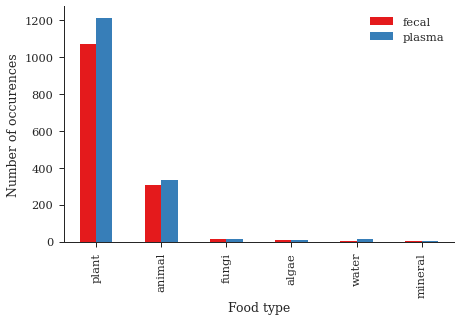

In [10]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

sample_counts_fecal_plasma.plot.bar(ax=ax)

ax.set_xlabel('Food type')
ax.set_ylabel('Number of occurences')

sns.despine()

plt.show()
plt.close()

### Food type at different metadata levels

In [11]:
sample_type_hierarchy = (
    pd.read_csv('../data/GFOP/sample_type_hierarchy.csv')
    .set_index('descriptor').sort_values('order_num'))

In [12]:
gnps_network_ibd = pd.read_csv(
    '../data/IBD seed/METABOLOMICS-SNETS-V2-907f2e0b-'
    'view_all_clusters_withID_beta-main.tsv', sep='\t')

In [13]:
def get_flows(gnps_network, sample_types, groups_included):
    groups = {f'G{i}' for i in range(1, 7)}
    groups_excluded = groups - set(groups_included)
    df_selected = gnps_network[
        (gnps_network[groups_included] > 0).all(axis=1) &
        (gnps_network[groups_excluded] == 0).all(axis=1)].copy()
    filenames = gnps_network['UniqueFileSources'].str.split('|').explode()
    idx = filenames.index
    sample_types_selected = sample_types.reindex(filenames)
    sample_types_selected['value'] = idx
    sample_types_selected = sample_types_selected.fillna('unmatched')
    flows, processes = [], []
    for i in range(1, 6):
        g1, g2 = f'sample_type_group{i}', f'sample_type_group{i + 1}'
        if (g1 in sample_types_selected.columns and
                g2 in sample_types_selected.columns):
            flow = (sample_types_selected.groupby([g1, g2])['value']
                    .size().reset_index()
                    .rename(columns={g1: 'source', g2: 'target'}))
            flow['source'] = flow['source'] + f'_{i}'
            flow['target'] = flow['target'] + f'_{i + 1}'
            flow['type'] = flow['source']
            flows.append(flow)
            process = pd.concat([flow['source'], flow['target']],
                                ignore_index=True).to_frame()
            process['level'] = [*np.repeat(i, len(flow['source'])),
                                *np.repeat(i + 1, len(flow['target']))]
            processes.append(process)
    return (pd.concat(flows, ignore_index=True),
            pd.concat(processes, ignore_index=True).drop_duplicates()
            .rename(columns={0: 'id'}).set_index('id'))

In [14]:
max_group = 5
samples_types_levels = get_sample_types(gfop_metadata, True)[
    [f'sample_type_group{i}' for i in range(1, max_group + 1)]]
flows, processes = get_flows(
    gnps_network_ibd, samples_types_levels, ['G1', 'G4'])
dataset = floweaver.Dataset(flows, dim_process=processes)

labels = (sample_type_hierarchy
          .reindex(set(flows['source']) | set(flows['target']))
          .sort_values('order_num').index)
nodes, ordering, bundles = {}, [], []
for level in processes['level'].unique():
    nodes[f'level {level}'] = floweaver.ProcessGroup(f'level == {level}')
    nodes[f'level {level}'].partition = floweaver.Partition.Simple(
        'process', labels[labels.str.endswith(f'_{level}')][::-1])
    
    ordering.append([f'level {level}'])
    
    if level + 1 in processes['level'].unique():
        bundles.append(floweaver.Bundle(f'level {level}',
                                        f'level {level + 1}'))

sdd = floweaver.SankeyDefinition(
    nodes, bundles, ordering, flow_partition=dataset.partition('type'))
palette = sample_type_hierarchy['color_code'].to_dict()
(floweaver.weave(sdd, dataset, palette=palette)
 .to_widget(width=4000, height=12000).auto_save_png('flow.png'))

SankeyWidget(groups=[{'id': 'level 1', 'type': 'process', 'title': '', 'nodes': ['level 1^unmatched_1', 'level…